# Black-Scholes - Monte Carlo Simulation - No dividends

> Author: Gustavo Monteiro de Athayde  
> Date: 15/03/2025



In [98]:
# dependencies
from IPython.display import display, clear_output

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Brigde part

In [99]:
# BS parameters
S0 = 100        # spot price
K = 100         # strike price
T = 1           # time to maturity
rf = 0.00       # risk-free rate
vol = 0.4       # volatility

In [100]:
# Monte Carlo simulation parameters
n = 1000000        # number of paths  - 5 min
n = 10000

# underlying parameters
mimc = (rf - vol**2/2)*(T/252)          # drift
volmc = vol/np.sqrt(252)
mi = rf - vol**2/2                      # drift (mi)

In [101]:
volmc

np.float64(0.02519763153394848)

## Direct approach

In [113]:
# let's simulate the paths - most dummy way
np.random.seed(0)
dt = T/n
t = np.linspace(0, T, n)
S = np.zeros((n, 252))

for i in range(n):
    S[i, 0] = S0
    for j in range(1, 252):
        S[i, j] = S[i, j-1]*np.exp(mimc + volmc * np.random.normal(0, 1))

df = pd.DataFrame(S)

## calculate call and put payoff
payoff_call = df.iloc[:,-1].apply(lambda v: max((v - K), 0))
payoff_put = df.iloc[:,-1].apply(lambda v: max((K - v), 0))

In [114]:
S.T

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [104.51208041,  98.52834099, 102.76841611, ...,  99.61047347,
        103.50438201,  94.92881119],
       [105.53769844,  98.85001049, 102.13126787, ..., 100.1082437 ,
        103.31557043,  94.33365476],
       ...,
       [117.12861043,  54.23668245,  34.0944611 , ..., 109.61192394,
        173.43637539,  88.61708183],
       [112.84381396,  54.74488655,  32.68607474, ..., 117.19226792,
        175.24525795,  91.60914488],
       [114.29888614,  54.68031011,  33.04681319, ..., 119.60644369,
        171.16626059,  92.72622912]], shape=(252, 10000))

Text(0.5, 1.0, 'Simulated paths')

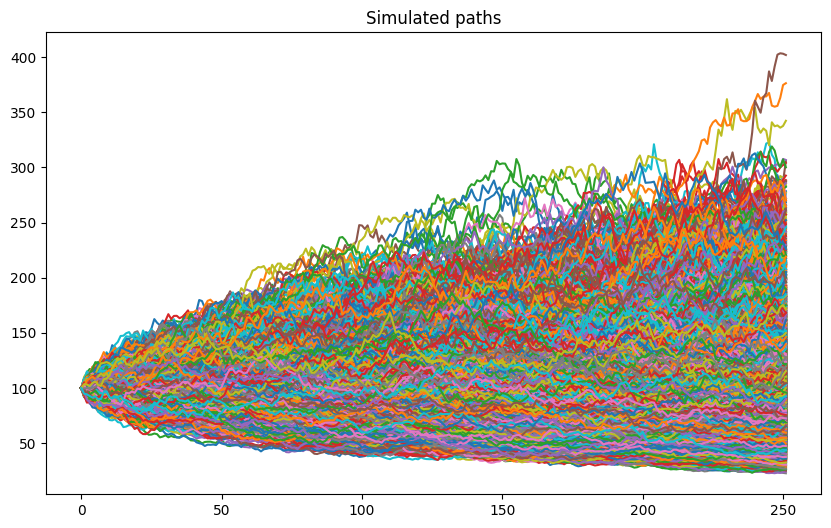

In [115]:
# plot the paths	
plt.figure(figsize=(10, 6))
plt.plot(S.T)
plt.title('Simulated paths')

## Monte Carlo Simulation using pandas

In [109]:
# pandas dataframe 252 days x 1000 paths
random_values = np.random.normal(0, 1, (n, 252))

# Create DataFrame
df = pd.DataFrame(random_values)

# calculate the underlying paths
df = df * volmc + mimc*dt
df = np.exp(df)
df = df.cumprod(axis=1) * S0

## calculate call and put payoff
payoff_call = df.iloc[:,-1].apply(lambda v: max((v - K), 0))
payoff_put = df.iloc[:,-1].apply(lambda v: max((K - v), 0))


<Axes: title={'center': 'Simulated paths'}>

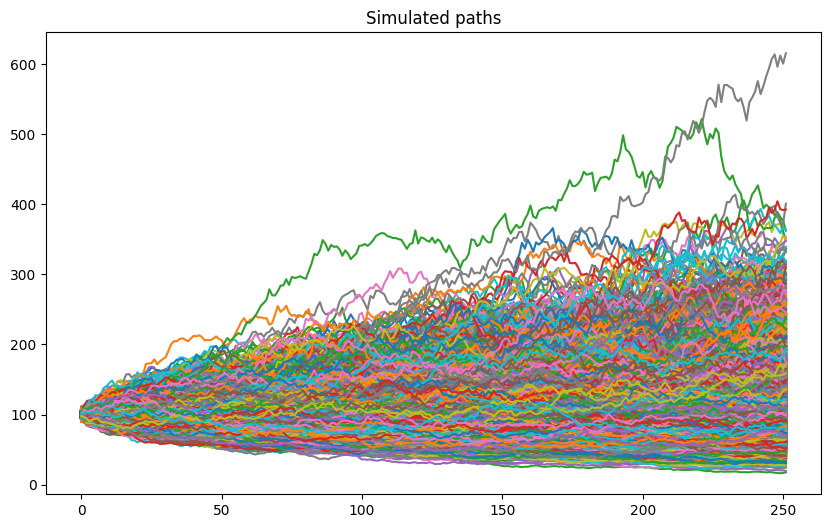

In [105]:
df.T.plot(legend=False, title='Simulated paths', figsize=(10, 6))

## Importing our library

```python
from lib import derivatives as dg
```

In [116]:

from lib import derivatives as dg

# Calculate BS and BSMC
E_ST_bs = S0*np.exp(rf*T)
E_ST_mc = np.mean(df.iloc[:,-1])

# Calculate call option price
call_bs = dg.bs_call_option(S0, K, T, rf, vol)
call_mc = np.mean(payoff_call) * np.exp(-rf * T)

summary = pd.DataFrame({
    'BS': [call_bs, E_ST_bs],
    'MC': [call_mc, E_ST_mc]
}, index=['Call option', 'Expected ST'])

summary


,BS,MC
Call option,15.851942,15.493945
Expected ST,100.000000,99.900669


In [108]:
payoff_call

0       50.412777
1       26.036495
2        0.000000
3        0.000000
4        0.000000
          ...    
9995     0.000000
9996     0.000000
9997     9.996325
9998    58.658979
9999     0.000000
Name: 251, Length: 10000, dtype: float64